In [1]:
# Check GPU

from tensorflow import test
from tensorflow.python.client import device_lib

if test.is_gpu_available:
    devices=device_lib.list_local_devices()
    gpu=[(x.physical_device_desc) for x in devices if x.device_type == 'GPU']
    print("GPU :", gpu)

GPU : ['device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']


In [2]:
# Check framework versions being used 

import sys
import keras as K
import tensorflow as tf

print("Python", sys.version)
print("Tensorflow version", tf.__version__)
print("Keras version", K.__version__)

Python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Tensorflow version 2.2.0-rc2
Keras version 2.2.5


Using TensorFlow backend.


In [0]:
# import NN architectures for speech recognition
from models import *

# import function for training acoustic model
from train_utils import train_model

In [4]:
# Import Additional Libraries

import re
import nltk

import numpy as np
import seaborn as sns
import _pickle as pickle
import matplotlib.pyplot as plt

from glob import glob
from nltk import trigrams
from nltk.corpus import brown
from utils import int_sequence_to_text
from collections import Counter, defaultdict
from data_generator import AudioGenerator, plot_raw_audio, plot_spectrogram_feature

from IPython.display import Markdown, display, Audio
from data_generator import vis_train_features, plot_mfcc_feature

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [6]:
sns.set_style(style = 'white')
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [7]:
# Extract label and audio features for a single training example

vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


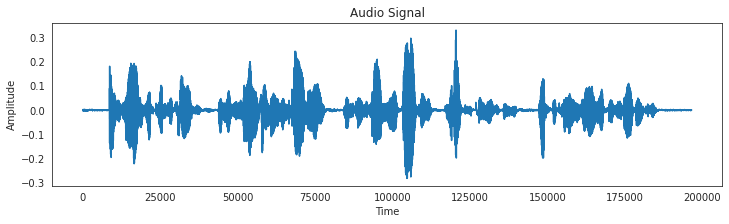

In [8]:
plot_raw_audio(vis_raw_audio)

In [9]:
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))

**Shape of Audio Signal** : (196576,)

In [10]:
display(Markdown('**Transcript** : ' + str(vis_text)))

**Transcript** : and now it had come to pass that his sole remaining ally mister samuel bozzle the ex policeman was becoming weary of his service

In [11]:
Audio(vis_audio_path)

#### Acoustic Features for Speech Recognition

We won't use the raw audio waveform as input to our model. <br />
Code first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models. <br />
Acoustic model will accept the feature representation as input. <br />
We will explore two possible feature representations. <br />

#### Spectrograms

The first option for an audio feature representation is the spectrogram. <br />
The code returns the spectrogram as a 2D tensor, where the first (vertical) dimension indexes time, and the second (horizontal) dimension indexes frequency. <br />
To speed the convergence of the algorithm, we have also normalized the spectrogram. (We can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

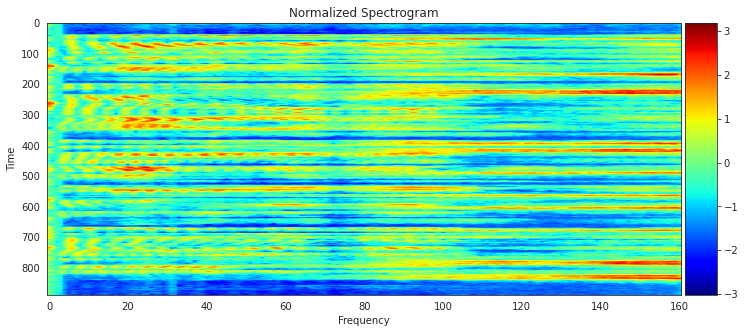

In [12]:
plot_spectrogram_feature(vis_spectrogram_feature)

In [13]:
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

**Shape of Spectrogram** : (890, 161)

#### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is MFCCs. <br />
Just as with the spectrogram features, the MFCCs are normalized in the supplied code. <br />
The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window. <br />
Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset.

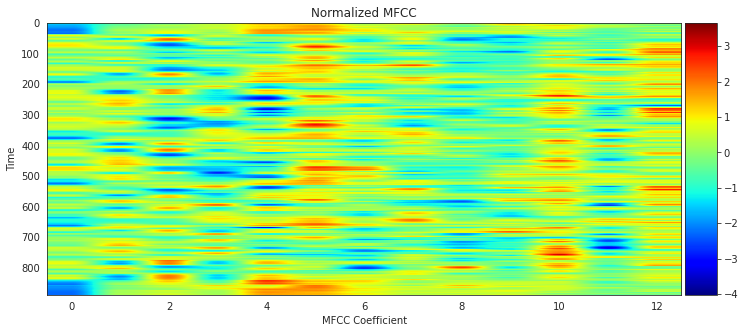

In [14]:
plot_mfcc_feature(vis_mfcc_feature)

In [15]:
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

**Shape of MFCC** : (890, 13)

In [16]:
# Model 0: SimpleRNN
model_0 = simple_rnn_model(input_dim = 161) # change to 13 if you would like to use MFCC features

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16704     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_________________________________________________________________
None


#### To train your architecture, we will use the train_model function within the train_utils module. 

The train_model function takes three required arguments: 

input_to_softmax - a Keras model instance. <br />
pickle_path - the name of the pickle file where the loss history will be saved. <br />
save_model_path - the name of the HDF5 file where the model will be saved. <br />
There are several optional arguments that allow you to have more control over the training process. <br />
minibatch_size - the size of the minibatches that are generated while training the model (default: 20). <br />
spectrogram - Boolean value dictating whether spectrogram (True) or MFCC (False) features are used for training (default: True). <br />
mfcc_dim - the size of the feature dimension to use when generating MFCC features (default: 13). <br />
optimizer - the Keras optimizer used to train the model (default: SGD(lr = 0.02, decay = 1e-6, momentum = 0.9, nesterov = True, clipnorm = 5)). <br />
epochs - the number of epochs to use to train the model (default: 20). If you choose to modify this parameter, make sure that it is at least 20. <br />
verbose - controls the verbosity of the training output in the model.fit_generator method (default: 1). <br />
sort_by_duration - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: False). <br />
The train_model function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in simple_rnn_model should have input_dim = 161. Otherwise, if you choose to use MFCC features, the acoustic model should have input_dim = 13. 

In [17]:
train_model(input_to_softmax = model_0, 
            pickle_path = 'model_0.pickle', 
            save_model_path = 'model_0.h5',
            minibatch_size = 128,
            spectrogram = True) # change to False if you would like to use MFCC features

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 1008.7255
Epoch 00001: saving model to results/model_0.h5
16/16 [==============================] - 59s 4s/step - loss: 1008.7255 - val_loss: 740.5802
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 757.4021
Epoch 00002: saving model to results/model_0.h5
16/16 [==============================] - 55s 3s/step - loss: 757.4021 - val_loss: 727.8657
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 754.2030
Epoch 00003: saving model to results/model_0.h5
16/16 [==============================] - 58s 4s/step - loss: 754.2030 - val_loss: 732.0170
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 755.3632
Epoch 00004: saving model to results/model_0.h5
16/16 [==============================] - 58s 4s/step - loss: 755.3632 - val_loss: 724.6930
Epoch 5/20
16/16 [==============================] - ETA: 0